# Multiomics modeling

Let's look at the paper *"Multiomics modeling of the immunome, transcriptome, microbiome, proteome and metabolome adaptations during human pregnancy"* by **Ghaemi et al. 2019** (`task1_multiomics_ghaemi2019multiomics.pdf`).
The idea is to use biological measurements to characterize biological changes during pregnancy.
The authors use multiple modalities (measurements collected from the immune system, microbiome, etc.)
This includes whether we can predict the gestational age of a mother solely based on the collected biomarkers.

**Note**: There is no need to get acquainted with multiomics modeling, at least for this exercise. In the end, this is just a regular data science task :) 

## Load the data

Load the data from `multiomics_data.pickle` using `pickle`. You will get a [pandas](https://pandas.pydata.org/docs/user_guide/10min.html) DataFrame containing preprocessed data from the paper (the original data from their paper is a bit messy). The data contains several meta attributes as well as the different modalities.

Meta attributes include:

* `Sex`: sex of the baby
* `timepoint`: 1-3 correspond to the three trimesters, 4 corresponds to postpartum
* `gestational_age`: time of sampling

Modalites are:
    
* `cellfree_rna`
* `metabolomics`
* `microbiome`
* `plasma_luminex`
* `serum_luminex`
* `immune_system`
* `plasma_somalogic`

Import Libraries

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time

from scipy.cluster.hierarchy import dendrogram, linkage
from fastcluster import linkage as fc_linkage

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.feature_selection import VarianceThreshold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, log_loss
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import make_pipeline

import plotly.graph_objs as go
import plotly.tools as tls
import plotly.offline as py

from scipy.stats import pearsonr

import xgboost as xgb
from xgboost import XGBRegressor 
import lightgbm as LGBMClassifier
from catboost import CatBoostRegressor

For more details pleaase see the paper.

In [2]:
# code for loading the data

with open("task1_multiomics_data.pickle", "rb") as file:
    data_multiomics = pickle.load(file)
    
data_multiomics.head(5)


Training/Validation Gates ID       MRN Study Subject ID Number     Sex  \
                                                                           
0                   T  PTLG002  16661779                   10565    Male   
1                   T  PTLG002  16661779                   10565    Male   
2                   T  PTLG002  16661779                   10565    Male   
3                   T  PTLG002  16661779                   10565    Male   
4                   T  PTLG004  23587868                   10603  Female   

  sex_bin timepoint gestational_age cellfree_rna                ...  \
                                       0_C2orf76      1_ACTL10  ...   
0       1         1              11     0.312437 -1.892930e-16  ...   
1       1         2              18     0.312437 -1.892930e-16  ...   
2       1         3              32     0.312437 -1.892930e-16  ...   
3       1         4              45     0.312437 -1.892930e-16  ...   
4       0         1              11     5.204209  1.734736e+00  ...   

  plasma_somalogic                                                             \
       1290_UBE2G2 1291_TAGLN2 1292_ATP5O 1293_POMC 1294_CRYZL1 1295_SERPINF1   
0           4804.4      2233.0     3610.9     715.8       151.4       37885.8   
1           4086.0      2160.5     2260.4     825.2       161.0       41821.5   
2           4328.0      1818.4     2445.2    1241.8       194.6       45526.1   
3           3442.4      2661.4     3879.2     703.6       153.7       36862.5   
4           4261.9      1804.6     1470.6     526.8       163.0       38938.3   

                                              
  1296_CTSF 1297_FTCD 1298_USP25 1299_PLXNB2  
0    1479.1    3261.8      561.3      3227.0  
1    1465.1    1839.8      597.8      3366.0  
2    1428.3    3057.2      625.7      8703.7  
3    1063.6    7339.7      593.2      2918.9  
4    1170.1    1036.8      552.8      3457.1  

[5 rows x 61274 columns]

<AxesSubplot:xlabel='gestational_age', ylabel='count'>

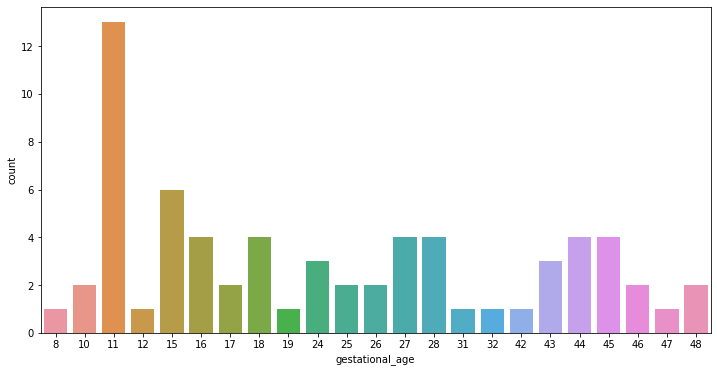

In [3]:
plt.figure(figsize=(12,6))

sns.countplot(x='gestational_age',data=data_multiomics)

In [4]:
g_age = data_multiomics['gestational_age']

In [5]:
data_multiomics["Training/Validation"].shape

(68,)

In [6]:
# look at the immune system
data_multiomics["immune_system"].head()


0_Bcells  1_CD16+CD56-NKcells  2_CD4+Tcells_mem  3_CD4+Tcells_naive  \
0  0.053164             0.054978          0.297875            0.136289   
1  0.052857             0.069794          0.279917            0.140350   
2  0.053202             0.050829          0.277997            0.187659   
3  0.049906             0.090496          0.266336            0.156263   
4  0.103067             0.004128          0.162746            0.103950   

   4_CD4+Tcells  5_CD45RA+Tregs  6_CD45RA-Tregs  7_CD56+CD16-NKcells  \
0      0.445832        0.002570        0.013848             0.007052   
1      0.430839        0.002470        0.010923             0.004759   
2      0.479078        0.003473        0.013359             0.005302   
3      0.432904        0.003071        0.014459             0.004318   
4      0.270840        0.003198        0.007988             0.007153   

   8_CD7+NKcells  9_CD8+Tcells_mem  ...  524_M-MDSC_STAT5_Unstim  \
0       0.070836          0.118884  ...                 0.998954   
1       0.080245          0.127831  ...                 0.930847   
2       0.063781          0.104513  ...                 1.077824   
3       0.101386          0.115243  ...                 0.976888   
4       0.090763          0.057064  ...                 0.890405   

   525_mDCs_STAT5_Unstim  526_ncMCs_STAT5_Unstim  527_pDCs_STAT5_Unstim  \
0               0.953637                1.082629               0.808610   
1               0.822618                0.931126               0.728738   
2               0.970954                1.011011               0.749277   
3               0.918164                1.028114               0.790166   
4               0.800468                1.067789               0.563615   

   528_Tbet+CD4+Tcells_mem_STAT5_Unstim  \
0                              0.504269   
1                              0.613059   
2                              0.752882   
3                              0.505349   
4                              0.464563   

   529_Tbet+CD4+Tcells_naive_STAT5_Unstim  \
0                                0.757424   
1                                0.852393   
2                                0.813249   
3                                0.648406   
4                                1.004497   

   530_Tbet+CD8+Tcells_mem_STAT5_Unstim  \
0                              0.462045   
1                              0.506981   
2                              0.560379   
3                              0.464522   
4                              0.378557   

   531_Tbet+CD8+Tcells_naive_STAT5_Unstim  532_TCRgd+Tcells_STAT5_Unstim  \
0                                0.454665                       0.443859   
1                                0.474408                       0.491691   
2                                0.481862                       0.505706   
3                                0.445444                       0.438285   
4                                0.423530                       0.332368   

   533_Tregs_STAT5_Unstim  
0                0.529431  
1                0.574133  
2                0.640245  
3                0.573058  
4                0.447904  

[5 rows x 534 columns]

In [7]:
imm_system = data_multiomics["immune_system"]

#for training the nueral network
imm_df = data_multiomics["immune_system"]

In [8]:
imm_system.describe()
variance = imm_system.var()

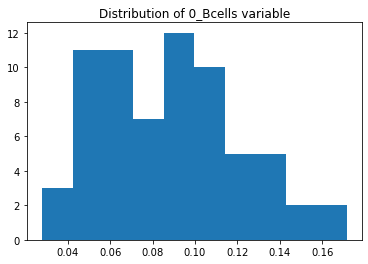

In [9]:
plt.hist(imm_system['0_Bcells']);
plt.title('Distribution of 0_Bcells variable');

In [10]:
model = make_pipeline(StandardScaler(),ElasticNet())
model.fit(imm_system,g_age)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('elasticnet', ElasticNet())])

In [11]:
elastic_weight = pd.DataFrame({
        "coef": model["elasticnet"].coef_ 
        }, 
    index=[f"feature {i}" for i in range(imm_system.shape[1])])
elastic_weight

coef
feature 0   -0.776404
feature 1   -0.000000
feature 2    0.000000
feature 3    0.007610
feature 4    0.109757
...               ...
feature 529 -0.000000
feature 530  0.000000
feature 531  0.000000
feature 532  0.000000
feature 533 -0.000000

[534 rows x 1 columns]

It shows that a lot of feature does not have effects on output

In [12]:
## this thershold is selected because it does not 
##cause a lot of variaty in data range.
var_thr = VarianceThreshold(threshold=(0.05))
var_thr.fit(imm_system)

# Get the mask of features that have variance greater than the threshold
selected_features = var_thr.get_support()

# Drop the features that have variance less than the threshold
df_dropped = imm_system.loc[:, selected_features]

imm_system = df_dropped
print(imm_system.shape)

(68, 143)


# EDA 

In [13]:
corr_matrix = imm_system.corr().abs()
print(corr_matrix.shape)

(143, 143)


In [14]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = [column for column in upper.columns if any(upper[column] >  0.95)]


# Drop the columns which are in the list 'to_drop' from the dataframe
df_cleaned = imm_system.drop(to_drop, axis=1)

# Now, you need to add back the feature with the highest variance among the dropped ones
max_variance_index = np.argmax(variance[to_drop])
max_variance_column = to_drop[max_variance_index]
df_final = pd.concat([df_cleaned, imm_system[[max_variance_column]]], axis=1)

print(df_final.shape)

(68, 88)


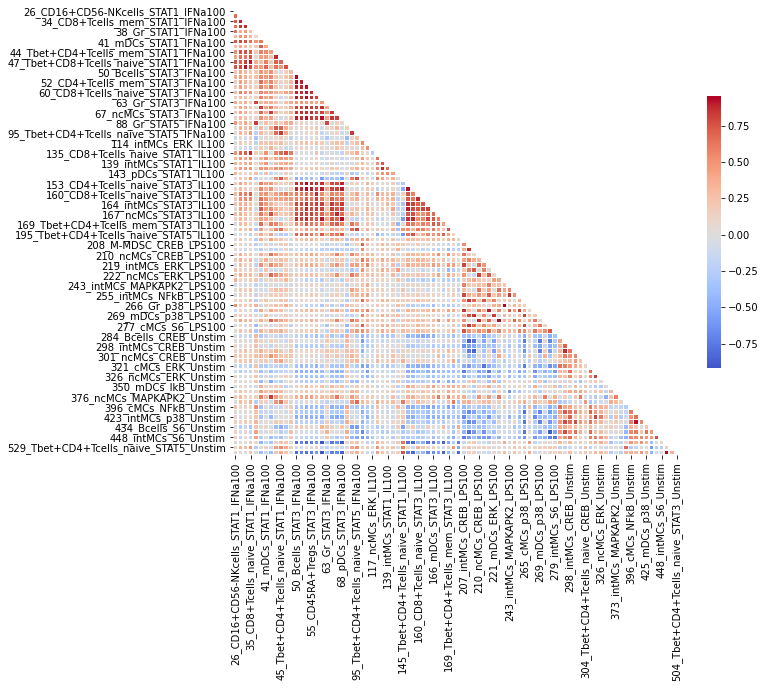

In [15]:
plt.figure(figsize=(10,  10))  # Adjust the size as needed

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(df_final.corr(), dtype=bool))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df_final.corr(), mask=mask, cmap='coolwarm', center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

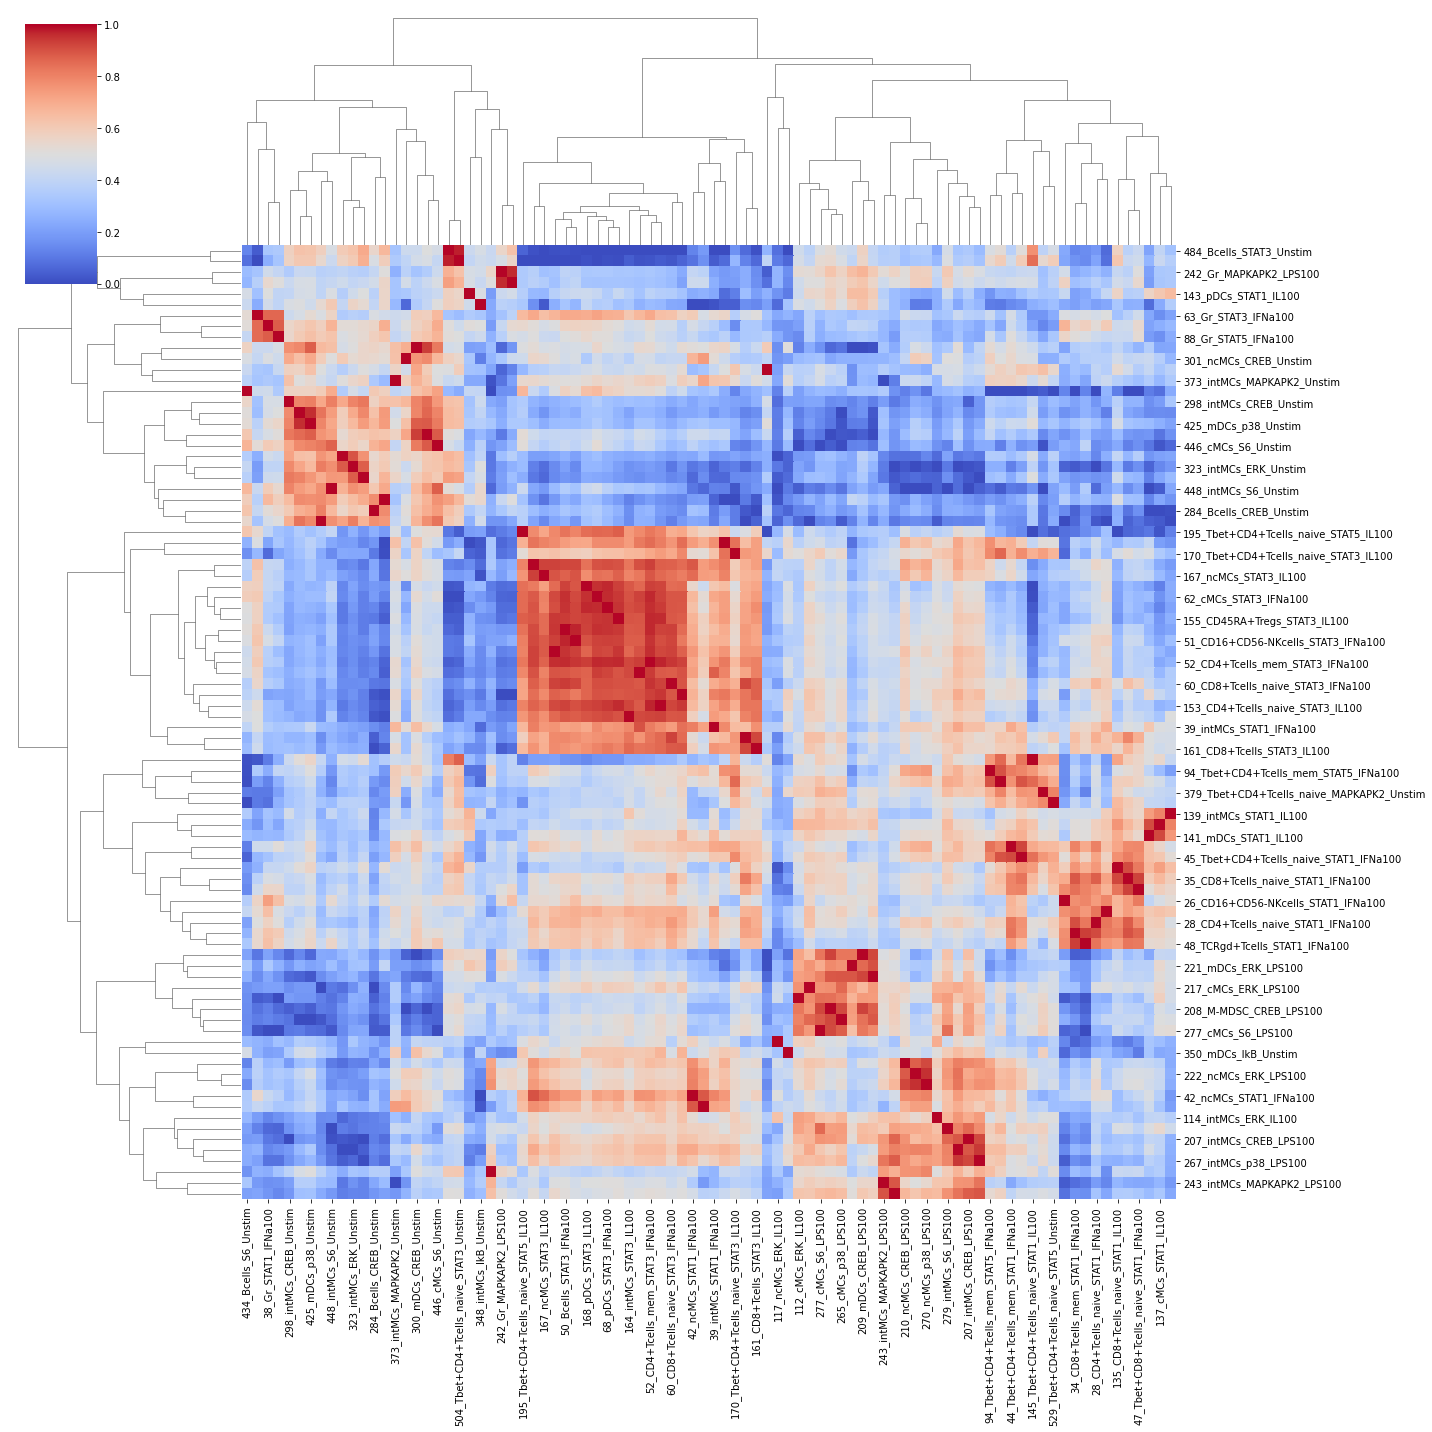

In [16]:
sns.clustermap(df_final.corr(), cmap='coolwarm', standard_scale=1, figsize=(20,  20))
plt.show()

see distribution of remain features

In [17]:
def view_feature_distributions(data_df, feature_names, n_columns=4, fig_size=(18, 16)):
    # Get number of features to plot
    n = len(feature_names)
    # Compute number of rows to use based on number of columns
    rows = n//n_columns
    if n%n_columns > 0:
        rows +=1
    
    # Plot feature distributions
    fig = plt.figure(figsize=fig_size)
    fig.tight_layout(h_pad=6)
    
    for _ in range(n):
        plt.subplot(rows, n_columns, _+1)
        plt.title(f'{feature_names[_]} distribution')
        sns.histplot(
            data=data_df[feature_names[_]], 
            kde=True, bins=100);

In [18]:
feature_name = df_final.columns.values.tolist()

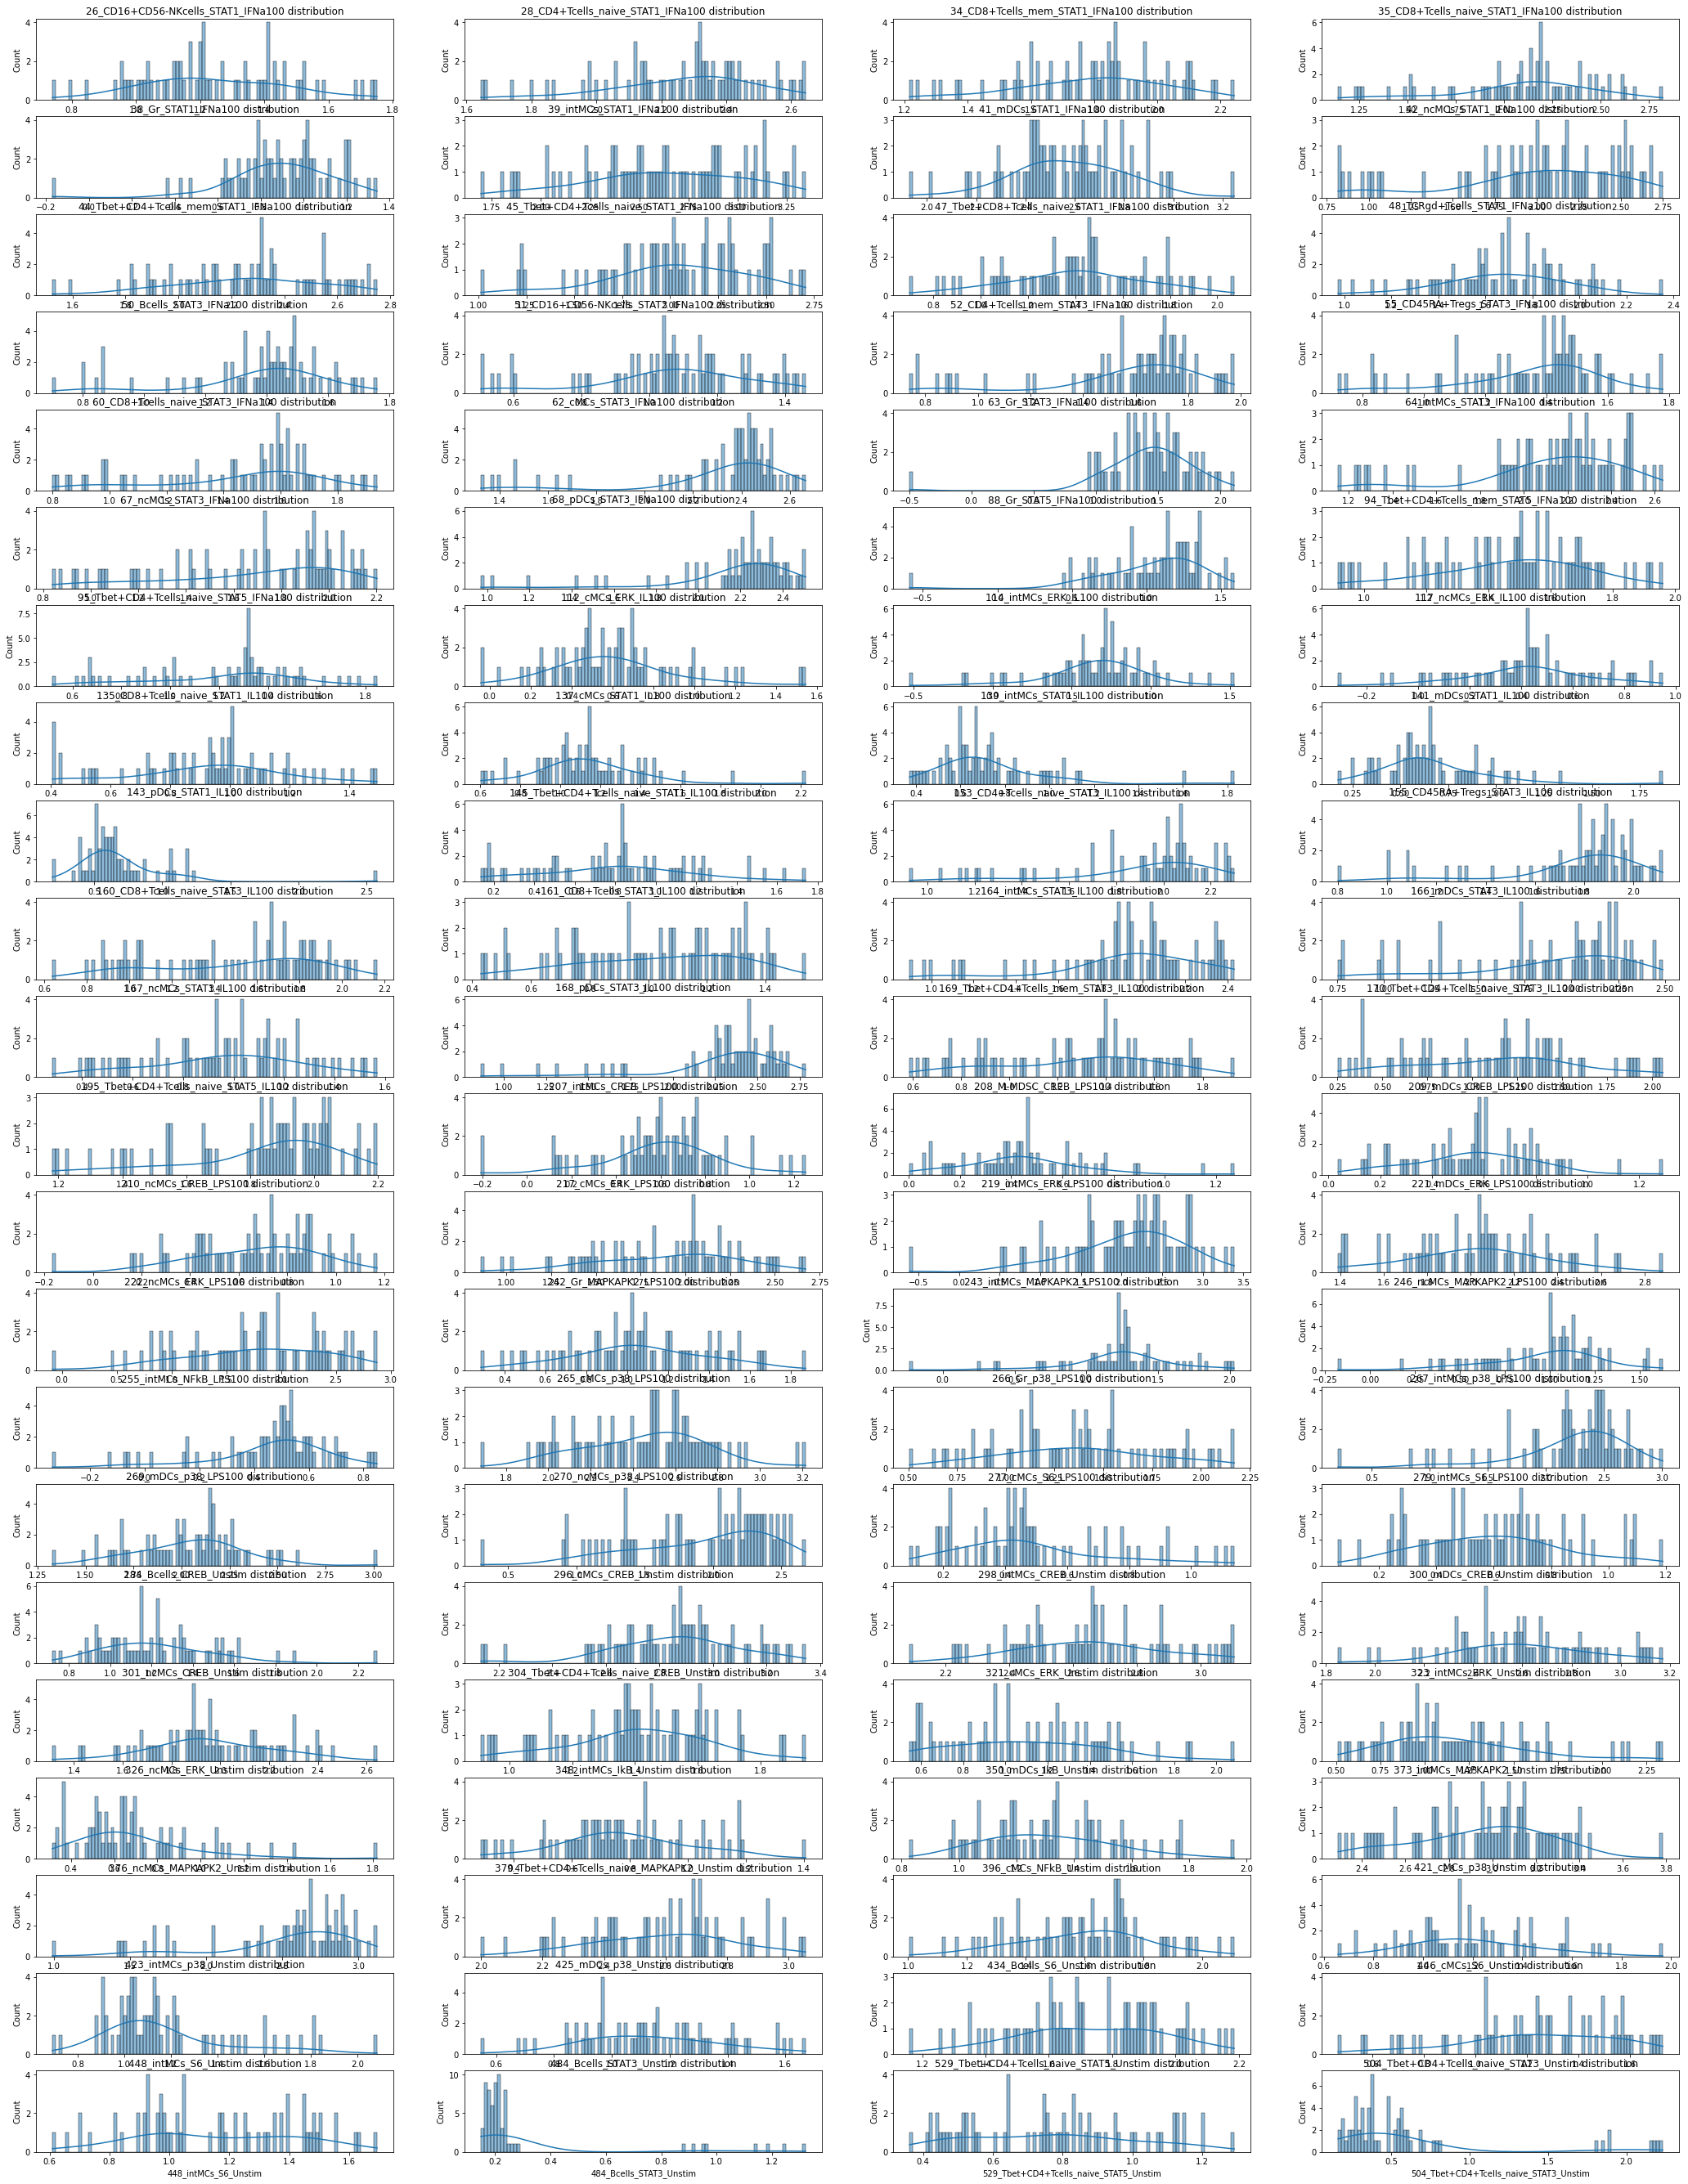

In [19]:
view_feature_distributions(df_final,feature_name, fig_size=(36, 48))

In [20]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_final)
pca = PCA(n_components=0.95)
pca.fit(scaled_data)
reduced_data = pca.transform(scaled_data)
reduced_df = pd.DataFrame(reduced_data)

print('Explained variance ratio: ', pca.explained_variance_ratio_)
print('Principal Components Loadings: \n', abs(pca.components_))

Explained variance ratio:  [0.26818851 0.16096443 0.13333729 0.08443388 0.0635099  0.03572857
 0.03468332 0.02324601 0.02011513 0.01756253 0.01603868 0.01408308
 0.01312772 0.01257912 0.01202706 0.01064195 0.00905853 0.00782505
 0.0070118  0.00599328]
Principal Components Loadings: 
 [[0.05133279 0.11597709 0.09141764 ... 0.12720236 0.03850552 0.11368382]
 [0.01891869 0.00275866 0.02701637 ... 0.13175944 0.10482685 0.14903711]
 [0.15908249 0.18034892 0.19933021 ... 0.15020616 0.10833432 0.16305476]
 ...
 [0.06311118 0.12202151 0.0086214  ... 0.05489941 0.17496953 0.05268862]
 [0.09604914 0.02952802 0.04654528 ... 0.02663324 0.03489785 0.02169306]
 [0.07010369 0.02018794 0.04620687 ... 0.0064293  0.25810208 0.08267428]]


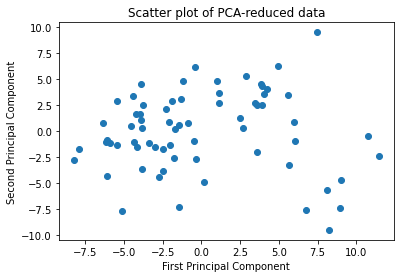

In [21]:
plt.scatter(reduced_data[:,  0], reduced_data[:,  1])
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Scatter plot of PCA-reduced data')
plt.show()

In [22]:
tsne = TSNE(n_components=3, random_state=0, perplexity=500, n_iter=5000)
tsne_data = tsne.fit_transform(scaled_data, g_age.values)
print(type(tsne_data))

<class 'numpy.ndarray'>


In [23]:
tracetsne = go.Scatter3d(
    x = tsne_data[:,0],
    y = tsne_data[:,1],
    z = tsne_data[:,2],
    mode = 'markers',
    text = g_age,
    showlegend = True,
    marker = dict(
        size = 8,
        color = g_age,
        colorscale ='Jet',
        showscale = False,
        line = dict(
            width = 2,
            color = 'rgb(255, 255, 255)'
        ),
        opacity = 0.8
    )
)
data = [tracetsne]

layout = go.Layout(
    title='t-SNE Dimensionality Reduction',
    scene=dict(
        xaxis=dict(title='Dimension  1'),
        yaxis=dict(title='Dimension  2'),
        zaxis=dict(title='Dimension  3')
    ),
    showlegend=False
)
fig = go.Figure(data=data, layout=layout)
fig.show()

In [24]:
lda = LDA(n_components=5)
# Taking in as second argument the Target as labels
X_LDA_2D = lda.fit_transform(scaled_data, g_age.values )

In [25]:
traceLDA = go.Scatter(
    x = X_LDA_2D[:,0],
    y = X_LDA_2D[:,1],
    mode = 'markers',
    text = g_age,
    showlegend = True,
    marker = dict(
        size = 10,
        color = g_age,
        colorscale ='Jet',
        showscale = False,
        line = dict(
            width = 2,
            color = 'rgb(255, 255, 255)'
        ),
        opacity = 0.8
    )
)
data = [traceLDA]

layout = go.Layout(
    title= 'Linear Discriminant Analysis (LDA)',
    hovermode= 'closest',
    xaxis= dict(
         title= 'First Linear Discriminant',
        ticklen= 5,
        zeroline= False,
        gridwidth= 2,
    ),
    yaxis=dict(
        title= 'Second Linear Discriminant',
        ticklen= 5,
        gridwidth= 2,
    ),
    showlegend= False
)

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='styled-scatter')

hint : I have test all of the above way of feature selection for my regressions algorithm bellow and I found that LDA have the best result. 

#  Training and test division

In [26]:
class CFG:
    SEED = 768
    NUM_FOLDS = 12

In [27]:
kfolds = KFold(
    n_splits=CFG.NUM_FOLDS, shuffle=True, 
    random_state=CFG.SEED
)

## Tasks

### Gestational Age

1. **Predict `gestational_age`** using the `immune_system` modality using at least two models (e.g., elastic net and support vector machines)

2. **Evaluate** your models using a measure that you think fits best. If it is a different measure than in the paper, please briefly explain why.

3. For your best model, **plot the model predictions** similar to **Figure 2D**.


**Hint:** To train and evaluate models, you can use [scikit-learn](https://scikit-learn.org/stable/tutorial/basic/tutorial.html).

**Figure 2D:**<br/>
<img src="assets/task1_multiomics_fig2d.jpeg">

# using XGboost for predicting the gestational age

In [28]:
# Define XGBoost Parameters
xgb_parameters = {
    'n_estimators'             : 256,
    'min_child_weight'         : 3,
    'max_depth'                : 10,
    'learning_rate'            : 0.1,
    'early_stopping_rounds'    : 256,
    'subsample'                : 0.96,
    'reg_lambda'               : 1.2,
    'reg_alpha'                : 1.2,
    'gamma'                    : 1.2,
    'max_bin'                  : 256,
    'random_state'             : CFG.SEED,
    'objective'                : 'reg:squarederror',
    'tree_method'              : 'hist',
    'eval_metric'              : 'rmse'
}
train_features = X_LDA_2D
train_targets = g_age

In [29]:
%%time
xgb_session = {
    'scores': [],
    'predictions': [],
    'models': []
}

# Train XGB models on folds
print('Training XGBoost Models')
for fold, (train_idx, val_idx) in enumerate(kfolds.split(train_features, train_targets)):
    print('----------------------------------')
    print(f"Training on Fold {fold + 1} ... \n")
    
    # Get Fold Training and Validation Split Data
    X_train, X_val = train_features[train_idx], train_features[val_idx]
    y_train, y_val = train_targets[train_idx], train_targets[val_idx]
    
    # Generate XBG Regressor
    xbg_model = XGBRegressor(**xgb_parameters)
    
    # Fit the Regressor
    start = time.perf_counter()
    xbg_model.fit(
        X_train, y_train, 
        eval_set=[(X_val, y_val)],
        verbose=0
    )
    end = time.perf_counter()
    
    # Compute total training time
    total_training_time = end - start
    
    # Generate & Record MAE
    val_predictions = xbg_model.predict(X_val)
    val_score = mean_absolute_error(y_val, val_predictions)
    xgb_session['scores'].append(val_score)
    
    # Print Training Time & MAE
    print(f'Time: {total_training_time:.2f}s\t| MAE: {val_score:.4f}')
    
    
    # Record Model
    xgb_session['models'].append(xbg_model)

# Print OOF MAE score
print('==================================')
print(f"\nOOF MAE: {np.mean(xgb_session['scores']):.4f}\n")
print('==================================')

Training XGBoost Models
----------------------------------
Training on Fold 1 ... 

Time: 0.72s	| MAE: 6.8643
----------------------------------
Training on Fold 2 ... 

Time: 0.14s	| MAE: 1.6760
----------------------------------
Training on Fold 3 ... 

Time: 0.15s	| MAE: 2.1320
----------------------------------
Training on Fold 4 ... 

Time: 0.14s	| MAE: 3.3578
----------------------------------
Training on Fold 5 ... 

Time: 0.15s	| MAE: 10.2482
----------------------------------
Training on Fold 6 ... 

Time: 0.15s	| MAE: 1.5391
----------------------------------
Training on Fold 7 ... 

Time: 0.15s	| MAE: 3.2088
----------------------------------
Training on Fold 8 ... 

Time: 0.14s	| MAE: 2.7231
----------------------------------
Training on Fold 9 ... 

Time: 0.14s	| MAE: 7.5069
----------------------------------
Training on Fold 10 ... 

Time: 0.15s	| MAE: 3.4743
----------------------------------
Training on Fold 11 ... 

Time: 0.14s	| MAE: 10.2766
--------------------------

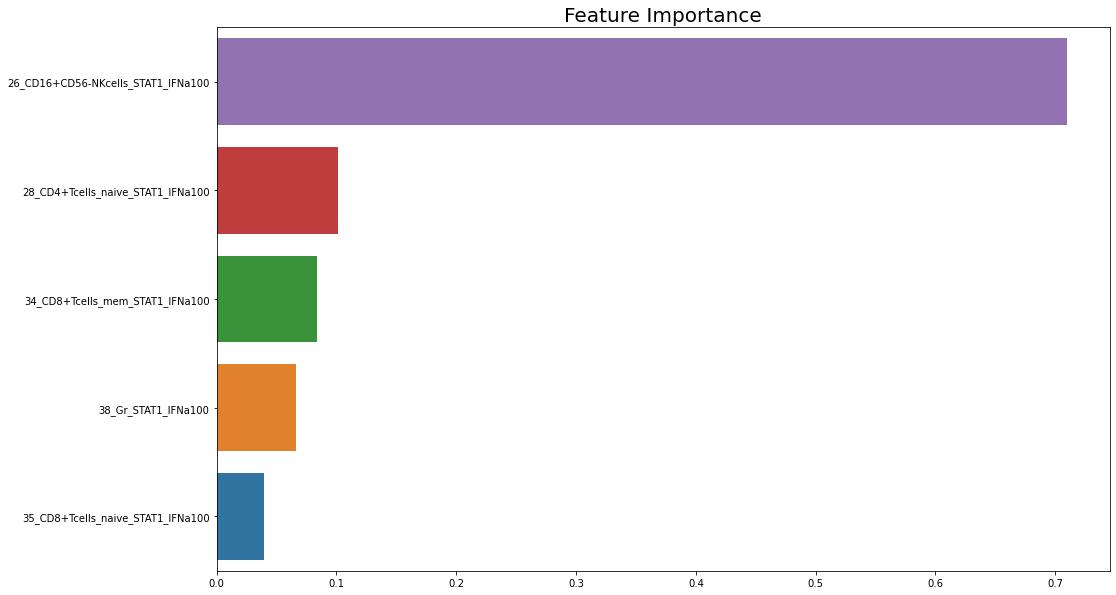

In [30]:
# Get feature importance from XGB session models
feature_importance = np.mean(np.array([model.feature_importances_ for model in xgb_session['models']]), axis=0)

# Generate plot of feature importance 
plt.figure(figsize=(16, 10))
plt.title('Feature Importance', fontsize=20)

sns.barplot(
    x=sorted(feature_importance),
    y=[feature_name[_] for _ in np.argsort(feature_importance)], 
    orient="h"
);

plt.gca().invert_yaxis();

# predicting gebtational age using Catboost

In [31]:
catboost_parameters = {
    'n_estimators'            : 384,
    'depth'                   : 6,
    'learning_rate'           : 0.1, 
    'l2_leaf_reg'             : 1.1,
    'min_data_in_leaf'        : 80,
    'random_seed'             : CFG.SEED,
    'loss_function'           : 'RMSE',
    'eval_metric'             : 'RMSE'
}

In [32]:
catboost_session = {
    'scores': [],
    'predictions': [],
    'models': []
}

# Train CatBoost models on folds
print('Training CatBoost Models')
for fold, (train_idx, val_idx) in enumerate(kfolds.split(train_features, train_targets)):
    print('-----------------------------------------------')
    print(f"Training on Fold {fold + 1} ... \n")
    
    # Get Fold Training and Validation Split Data
    X_train, X_val = train_features[train_idx], train_features[val_idx]
    y_train, y_val = train_targets[train_idx], train_targets[val_idx]
    
    # Generate CatBoost Regressor
    catboost_model = CatBoostRegressor(**catboost_parameters)
    
    # Fit the Regressor
    start = time.perf_counter()
    catboost_model.fit(
        X_train, y_train, 
        eval_set=[(X_val, y_val)],
        verbose=0
    )
    end = time.perf_counter()
    
    # Compute total training time
    total_training_time = end - start
    
    # Generate & Record MAE Score
    val_predictions = catboost_model.predict(X_val)
    val_score = mean_absolute_error(y_val, val_predictions)
    catboost_session['scores'].append(val_score)
    
    # Print Training Time & MAE
    print(f'Time: {total_training_time:.2f}s | mae: {val_score:.4f}')
    
    
    # Record Model
    catboost_session['models'].append(catboost_model)

# Print OOF MAE score
print('==================================')
print(f"\nOOF MAE: {np.mean(catboost_session['scores']):.4f}\n")
print('==================================')

Training CatBoost Models
-----------------------------------------------
Training on Fold 1 ... 

Time: 0.55s | mae: 8.3486
-----------------------------------------------
Training on Fold 2 ... 

Time: 0.36s | mae: 2.4461
-----------------------------------------------
Training on Fold 3 ... 

Time: 0.37s | mae: 1.9235
-----------------------------------------------
Training on Fold 4 ... 

Time: 0.40s | mae: 4.1558
-----------------------------------------------
Training on Fold 5 ... 

Time: 0.36s | mae: 7.4728
-----------------------------------------------
Training on Fold 6 ... 

Time: 0.36s | mae: 2.8969
-----------------------------------------------
Training on Fold 7 ... 

Time: 0.36s | mae: 3.5732
-----------------------------------------------
Training on Fold 8 ... 

Time: 0.36s | mae: 5.2603
-----------------------------------------------
Training on Fold 9 ... 

Time: 0.36s | mae: 8.1711
-----------------------------------------------
Training on Fold 10 ... 

Time: 0.37

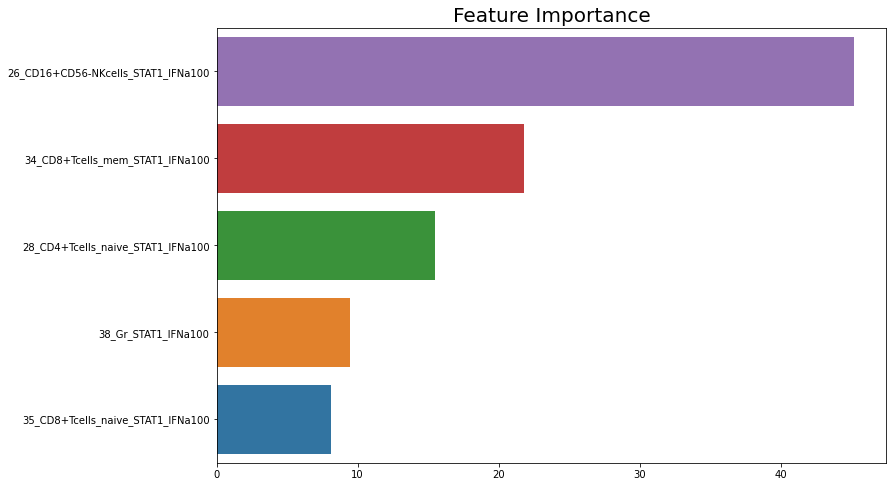

In [33]:
feature_importance = np.mean(np.array([model.get_feature_importance() for model in catboost_session['models']]), axis=0)

# Generate plot of feature importance 
plt.figure(figsize=(12, 8))
plt.title('Feature Importance', fontsize=20)

sns.barplot(
    x=sorted(feature_importance),
    y=[feature_name[_] for _ in np.argsort(feature_importance)], 
    orient="h"
);

plt.gca().invert_yaxis();

### Sex of the baby

Importing essential library for this task

In [34]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adamax
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.regularizers import l1, l2

(68,)


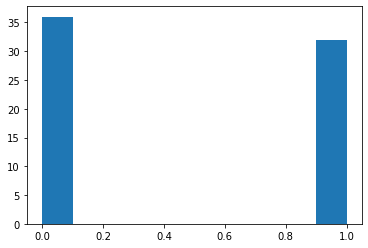

In [35]:
sex_baby = data_multiomics['sex_bin']
plt.hist(sex_baby)
print(sex_baby.shape)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_LDA_2D, sex_baby, test_size=0.2, random_state=42)


In [37]:
model = Sequential()
model.add(Dense(16, activation='relu', input_dim=5))  # Input layer with  5 features
model.add(Dense(8, activation='relu'))                # Hidden layer
model.add(Dense(1, activation='sigmoid'))  

In [38]:
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

In [44]:
model.fit(X_train, y_train, epochs=50, batch_size=30, validation_split=0.2)

Epoch 1/50
2/2 [==============================] - 0s 93ms/step - loss: 0.5868 - accuracy: 0.7143 - val_loss: 0.6366 - val_accuracy: 0.6923
Epoch 2/50
2/2 [==============================] - 0s 48ms/step - loss: 0.5862 - accuracy: 0.7143 - val_loss: 0.6376 - val_accuracy: 0.6154
Epoch 3/50
2/2 [==============================] - 0s 47ms/step - loss: 0.5858 - accuracy: 0.7143 - val_loss: 0.6387 - val_accuracy: 0.6154
Epoch 4/50
2/2 [==============================] - 0s 58ms/step - loss: 0.5851 - accuracy: 0.7143 - val_loss: 0.6398 - val_accuracy: 0.6154
Epoch 5/50
2/2 [==============================] - 0s 64ms/step - loss: 0.5845 - accuracy: 0.7143 - val_loss: 0.6409 - val_accuracy: 0.6154
Epoch 6/50
2/2 [==============================] - 0s 56ms/step - loss: 0.5839 - accuracy: 0.7143 - val_loss: 0.6422 - val_accuracy: 0.5385
Epoch 7/50
2/2 [==============================] - 0s 40ms/step - loss: 0.5833 - accuracy: 0.7143 - val_loss: 0.6438 - val_accuracy: 0.5385
Epoch 8/50
2/2 [===========

In [45]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Test accuracy: ", accuracy)

1/1 [==============================] - 0s 33ms/step - loss: 0.6730 - accuracy: 0.7143
Test accuracy:  0.7142857313156128


# Using LightGBM to classify the sex of baby

In [54]:
import lightgbm as lgbm  # standard alias

clf = lgbm.LGBMClassifier(objective="binary")  # or 'mutliclass'
#scores = []

In [60]:
%%time

lgbm_session = {
    'scores': [],
    'predictions': [],
    'models': []
}

# Train lightGBM models on folds
print('Training lightGBM Models')
for fold, (train_idx, val_idx) in enumerate(kfolds.split(train_features, sex_baby)):
    print('----------------------------------')
    print(f"Training on Fold {fold + 1} ... \n")
    
    # Get Fold Training and Validation Split Data
    X_train, X_val = train_features[train_idx], train_features[val_idx]
    y_train, y_val = sex_baby[train_idx], sex_baby[val_idx]
    
    # Generate lgbm Regressor
    lgbm_clf = lgbm.LGBMClassifier(
    objective="binary",
    n_estimators=8,
    learning_rate=0.01,
    random_state=42,
    num_leaves=5,  # Adjust num_leaves
    min_data_in_leaf=10,  # Adjust min_data_in_leaf
    early_stopping_rounds=10  # Enable early stopping
    )
    # Fit the Regressor
    start = time.perf_counter()
    lgbm_clf.fit(
        X_train, y_train, 
        eval_set=[(X_val, y_val)],
        #verbose=0
    )
    end = time.perf_counter()
    
    # Compute total training time
    total_training_time = end - start
    
    preds = lgbm_clf.predict_proba(X_val)
    loss = log_loss(y_val, preds)
    lgbm_session['scores'].append(loss)
    runtime = time.time() - start
    print(f"Fold {fold} finished with score: {loss:.5f} in {runtime:.2f} seconds.\n")
       
    
    # Record Model
    lgbm_session['models'].append(lgbm_clf)

# Print OOF MAE score
print('==================================')
print(f"\nOOF binary_loss: {np.mean(lgbm_session['scores']):.4f}\n")
print('==================================')

Training lightGBM Models
----------------------------------
Training on Fold 1 ... 

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 29, number of negative: 33
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 112
[LightGBM] [Info] Number of data points in the train set: 62, number of used features: 5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] early_stopping_round is set=10, early_stoppin

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 29, number of negative: 34
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 112
[LightGBM] [Info] Number of data points in the train set: 63, number of used features: 5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Info]

Try using a neural network in Tensorflow or PyTorch to predict the sex of the baby.

### Feedback

Were the tasks above difficult, easy, or a mixture? In both cases, briefly describe why.

To me, the most difficult part was feature extraction. the number of records was so low and there wasn't enough to extract important feature among 560 features. If I had more data I easily can Autoencoder to extract best features and I would achieve higher accuracy. 